In [1]:
import os
import sys
sys.path.append('..')  
import random
import pickle
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from scipy.stats import zscore
from scipy.stats import spearmanr
from scipy.stats import ranksums

In [5]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ks_2samp, rankdata
from joblib import Parallel, delayed

In [6]:
from scregat.data_process import prepare_model_input, sum_counts, plot_edge, ATACGraphDataset
from run_scReGAT import *

/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [7]:
# load graph

In [8]:
with open('../data/dataset_atac_core_OB.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [9]:
dataset_atac.list_graph[0]

Data(x=[158604, 1], edge_index=[2, 243914], y=[1], edge_tf=[18112, 2], y_exp=[3485], cell='HCA_BN_F12863835_and_HCA_BN_F12865000-TAAAGCCTCATGCATA')

In [10]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [11]:
model = SCReGAT()

In [12]:
cells = dataset_atac.adata.obs_names.values

In [13]:
test_cell = random.sample(list(cells),int(len(cells) *0.5))

In [14]:
num_epoch = 4
leanring_rate = 1e-4

In [15]:
# load scRNA

In [16]:
rna_adata = sc.read_h5ad("../data/scRNA_OB.h5ad")

In [17]:
rna_adata

AnnData object with n_obs × n_vars = 21550 × 33958
    obs: 'batch', 'pcw', 'celltype'
    var: 'modality'

In [18]:
balanced_train_graph, test_graph = preprocess_graph(dataset_atac, test_cell, max_random_sample=0, seed=seed, if_test=False,is_balances=False)

Preprocess Start!



rocessing samples: 100%|██████████| 21119/21119 [00:07<00:00, 2788.29it/s]

train_graph: 10560
test_graph: 10559
random max_values: 4.614475250244141


Processing samples: 0it [00:00, ?it/s]

adding random nodes...: 0


In [19]:
gene_list = [t for t in dataset_atac.array_peak if not t.startswith('chr')]
gene_list = np.array(gene_list)
rna_adata = rna_adata[:, gene_list]

In [20]:
cells = [t.cell for t in balanced_train_graph]
cells_test = [t.cell for t in test_graph]
train_exp_mt = rna_adata[cells, :].X.toarray()
test_exp_mt = rna_adata[cells_test, :].X.toarray()

In [21]:
single_balanced_graph = []
for idx, t in tqdm(enumerate(balanced_train_graph), total=len(balanced_train_graph), desc="Processing graphs"):
    t.y_exp = torch.tensor(train_exp_mt[idx, :] / np.sum(train_exp_mt[idx, :]), dtype=torch.float32) 
    single_balanced_graph.append(t)



rocessing graphs: 100%|██████████| 10560/10560 [00:00<00:00, 11719.60it/s]

In [22]:
model = train_model(model, single_balanced_graph, num_epoch=num_epoch, batch_size=4, lr=leanring_rate, max_grad_norm=1.0, sparse_loss_weight=0.1,
                    if_zero=False,use_device=device)


poch 1/4: 100%|██████████| 2640/2640 [13:26<00:00,  3.27batch/s, loss=0.201, loss1=0.0615, sparse_loss=0.14]

Epoch [1/4], Average Loss: 0.2013, Loss1: 0.0615, Sparse Loss: 0.1398



poch 2/4: 100%|██████████| 2640/2640 [13:53<00:00,  3.17batch/s, loss=0.139, loss1=6.55e-6, sparse_loss=0.139]

Epoch [2/4], Average Loss: 0.1386, Loss1: 0.0000, Sparse Loss: 0.1386



poch 3/4: 100%|██████████| 2640/2640 [16:07<00:00,  2.73batch/s, loss=0.138, loss1=4.45e-6, sparse_loss=0.138]

Epoch [3/4], Average Loss: 0.1381, Loss1: 0.0000, Sparse Loss: 0.1381


Epoch 4/4: 100%|██████████| 2640/2640 [20:00<00:00,  2.20batch/s, loss=0.138, loss1=4.11e-6, sparse_loss=0.138]

Epoch [4/4], Average Loss: 0.1378, Loss1: 0.0000, Sparse Loss: 0.1378


In [22]:
# add edge_tf

In [23]:
base_edge = dataset_atac.list_graph[0].edge_index
gene_edge = dataset_atac.list_graph[0].edge_tf
indices_not_equal = torch.nonzero(gene_edge[:, 0] != gene_edge[:, 1]).squeeze()
gene_edge = gene_edge[indices_not_equal, ].T
all_edges = torch.vstack((base_edge.T, gene_edge.T)).T
all_edges.shape 

torch.Size([2, 262020])

In [24]:
for t in dataset_atac.list_graph:
    t.edge_index = all_edges

In [25]:
dataset_atac.list_graph[0] 

Data(x=[158604, 1], edge_index=[2, 262020], y=[1], edge_tf=[18112, 2], y_exp=[3485], cell='HCA_BN_F12863835_and_HCA_BN_F12865000-TAAAGCCTCATGCATA', id_vec=[158604], seq_data=1)

In [27]:
res_edge, test_barcodes = test_model(dataset_atac, model, dataset_atac.list_graph, batch_size=6, device=device, if_test=False)


rocessing Batches: 100%|██████████| 3520/3520 [23:11<00:00,  2.53it/s]

In [28]:
#torch.save(model.state_dict(), model_weight_file)

In [29]:
adata_edge = ad.AnnData(X=res_edge, obs=dataset_atac.adata.obs.loc[test_barcodes,])

# 1.Smoothed Expression and Regulatory Probabilities Along Pseudotime

In [30]:
# load data

In [31]:
with open('../data/dataset_atac_core_OB.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [32]:
base_edge = dataset_atac.list_graph[0].edge_index
gene_edge = dataset_atac.list_graph[0].edge_tf
indices_not_equal = torch.nonzero(gene_edge[:, 0] != gene_edge[:, 1]).squeeze()
gene_edge = gene_edge[indices_not_equal, ].T
all_edges = torch.vstack((base_edge.T, gene_edge.T)).T
all_edges.shape #
for t in dataset_atac.list_graph:
    t.edge_index = all_edges

In [33]:
dataset_atac.list_graph[0]

Data(x=[158604, 1], edge_index=[2, 262020], y=[1], edge_tf=[18112, 2], y_exp=[3485], cell='HCA_BN_F12863835_and_HCA_BN_F12865000-TAAAGCCTCATGCATA')

In [34]:
adata_edge = sc.read_h5ad("../data/scRP_OB.h5ad")
adata_edge

AnnData object with n_obs × n_vars = 21119 × 262020
    obs: 'batch', 'pcw', 'celltype', 'celltype_rna', 'nb_features'

In [35]:
adata_rna = sc.read_h5ad("../data/scRNA_OB.h5ad")
adata_rna

AnnData object with n_obs × n_vars = 21550 × 33958
    obs: 'batch', 'pcw', 'celltype'
    var: 'modality'

In [36]:
adata_rna = adata_rna[ adata_edge.obs_names,]

In [37]:
adata_rna

View of AnnData object with n_obs × n_vars = 21119 × 33958
    obs: 'batch', 'pcw', 'celltype'
    var: 'modality'

In [38]:
pseudotime = pd.read_csv("../data/Pseudotime_OB.csv",index_col=0)

In [39]:
pseudotime = pseudotime.loc[adata_rna.obs_names,]

In [40]:
adata_rna.obs = pseudotime

In [41]:
adata_rna

AnnData object with n_obs × n_vars = 21119 × 33958
    obs: 'celltype', 't'
    var: 'modality'

In [42]:
def plot_gene_expression_and_regulatory_score(
    rna, 
    ris, 
    edge_info, 
    gene, 
    plot_raw=False,
    smoothing_param=0.1,
    width=15,
    height=8
):
    """Plot gene expression and regulatory score across pseudotime with dual y-axes.
    
    Args:
        rna: RNA-seq data (AnnData object)
        ris: Regulatory interaction scores (AnnData object)
        edge_info: DataFrame with edge information
        gene: Target gene to plot
        plot_raw: Whether to show raw data points
        smoothing_param: Parameter for moving average smoothing (fraction of data points)
        width: Figure width in cm
        height: Figure height in cm
        
    Returns:
        DataFrame containing all plotted data
    """
    # Set Nature style
    sns.set_style("white")
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': 7,
        'axes.linewidth': 0.5,
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'pdf.fonttype': 42
    })

    # Nature style colors
    expression_color = "#d62728"  # Red
    regulatory_color = "#1f77b4"  # Blue
    
    # Extract data
    pseudotime = rna.obs['t'].values
    gene_expression = rna[:, gene].X.toarray().flatten()
    
    # Calculate median regulatory score (simplified from original)
    reg_scores = ris[:, edge_info.loc[edge_info.gene == gene].index].X
    regulatory_score = np.median(reg_scores, axis=1)
    regulatory_score[regulatory_score < 0] = 0  # Remove negative values
    
    # Sort by pseudotime
    sort_idx = np.argsort(pseudotime)
    pseudotime = pseudotime[sort_idx]
    gene_expression = gene_expression[sort_idx]
    regulatory_score = regulatory_score[sort_idx]
    
    # Apply moving average smoothing (simplified from original)
    def moving_average(x, y, param):
        window = max(3, int(param * len(y)))
        weights = np.ones(window) / window
        smoothed = np.convolve(y, weights, mode='same')
        return x, smoothed

    pt_smooth, exp_smooth = moving_average(pseudotime, gene_expression, smoothing_param)
    _, reg_smooth = moving_average(pseudotime, regulatory_score, smoothing_param)

    # Create DataFrame for return
    data = pd.DataFrame({
        'pseudotime': pseudotime,
        'gene_expression': gene_expression,
        'regulatory_score': regulatory_score,
        'pseudotime_smooth': pt_smooth,
        'expression_smooth': exp_smooth,
        'regulatory_smooth': reg_smooth
    })

    # Set figure dimensions
    fig_width_in = width / 2.54
    fig_height_in = height / 2.54

    # Create figure with primary axis
    fig, ax1 = plt.subplots(figsize=(fig_width_in, fig_height_in))

    # Plot expression on primary axis
    ax1.plot(pt_smooth, exp_smooth, color=expression_color, linewidth=1.2, label='Expression')
    ax1.set_xlabel('Pseudotime', fontsize=9)
    ax1.set_ylabel('Expression', color=expression_color, fontsize=9)
    ax1.tick_params(axis='y', labelcolor=expression_color, length=2, width=0.5, pad=2, labelsize=7)

    # Create secondary axis for regulatory score
    ax2 = ax1.twinx()
    ax2.plot(pt_smooth, reg_smooth, color=regulatory_color, linewidth=1.2, label='Regulatory activity')
    ax2.set_ylabel('Regulatory score', color=regulatory_color, fontsize=9)
    ax2.tick_params(axis='y', labelcolor=regulatory_color, length=2, width=0.5, pad=2, labelsize=7)

    # Add raw data if requested
    if plot_raw:
        ax1.scatter(pseudotime, exp_smooth, color=expression_color, s=3, alpha=0.3, label='Raw expression')
        ax2.scatter(pseudotime, reg_smooth, color=regulatory_color, s=3, alpha=0.3, label='Raw regulatory activity')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2, 
        labels1 + labels2, 
        loc='upper left', 
        bbox_to_anchor=(0, 1), 
        fontsize=7, 
        frameon=False
    )

    # Final styling
    sns.despine(ax=ax1, right=False)
    sns.despine(ax=ax2, left=False)
    ax1.set_title(f'{gene} expression and regulatory activity across pseudotime', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return data

In [43]:
edge_info = get_edge_info(dataset_atac)
edge_info = edge_info.loc[edge_info.peak.str.contains('chr')]
edge_info

,peak,gene
0,chr1-921649-922149,SAMD11
1,chr1-923610-924110,SAMD11
2,chr1-924576-925076,SAMD11
3,chr1-925426-925926,SAMD11
4,chr1-957277-957777,NOC2L
...,...,...
243909,chrX-154980786-154981286,PLXNA3
243910,chrX-155010085-155010585,DKC1
243911,chrX-155010085-155010585,PLXNA3
243912,chrX-155070539-155071039,DKC1


In [44]:
adata_edge = adata_edge[:,edge_info.index]
adata_edge

View of AnnData object with n_obs × n_vars = 21119 × 243914
    obs: 'batch', 'pcw', 'celltype', 'celltype_rna', 'nb_features'

In [45]:
adata_rna = adata_rna[adata_edge.obs_names,]
adata_rna

View of AnnData object with n_obs × n_vars = 21119 × 33958
    obs: 'celltype', 't'
    var: 'modality'

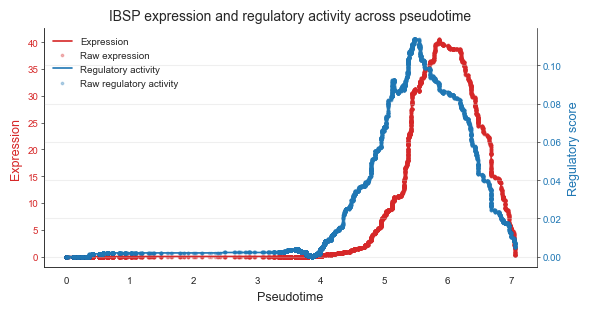

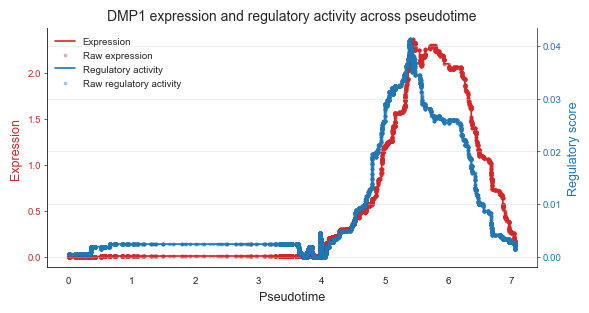

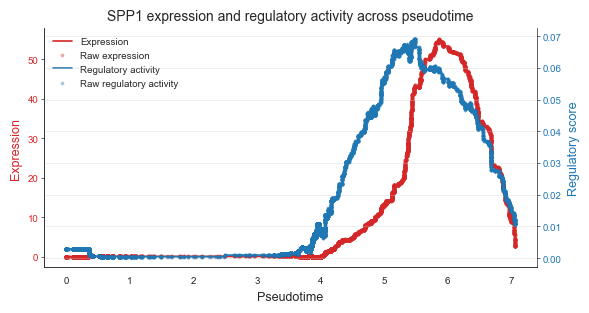

In [46]:
data = {}
for i in ["IBSP","DMP1","SPP1"]:
    data[i] = plot_gene_expression_and_regulatory_score(adata_rna,adata_edge, edge_info, i, plot_raw=True, smoothing_param=0.1)

# 2. Lag in Gene Expression

In [47]:
df_rp = pd.DataFrame(adata_edge.X,columns = edge_info['gene'].values )

In [48]:
df_rp_by_gene = df_rp.groupby(level=0, axis=1).median()

In [49]:
df_rp_by_gene.index = adata_edge.obs_names

In [50]:
adata_rp = ad.AnnData(X=np.array(df_rp_by_gene),obs=adata_edge.obs,var = pd.DataFrame(df_rp_by_gene.columns,index=df_rp_by_gene.columns))
adata_rp

AnnData object with n_obs × n_vars = 21119 × 3485
    obs: 'batch', 'pcw', 'celltype', 'celltype_rna', 'nb_features'
    var: 0

In [51]:
common_genes = np.intersect1d(adata_rna.var_names,adata_rp.var_names)

In [52]:
adata_rp  = adata_rp[:,common_genes]
adata_rna = adata_rna[:,common_genes]

In [53]:
adata_rp.obs = adata_rp.obs

In [54]:
marker = pd.read_excel("../data/marker.xlsx",sheet_name=2)

In [55]:
target_celltypes = ['SutureMes1', 'SutureMes2', 'Osteocyte', 'CranialMes', 'Osteoblast',"HHIP+ PreOB"]
filtered_marker = marker[marker.celltype.isin(target_celltypes)]
top_genes_per_celltype = filtered_marker.groupby('celltype').apply(
    lambda x: x.nlargest(30, 'logfoldchanges')
).reset_index(drop=True)

In [56]:
top_genes_per_celltype.celltype.value_counts()

CranialMes     30
HHIP+ PreOB    30
Osteoblast     30
Osteocyte      30
SutureMes1     30
SutureMes2     30
Name: celltype, dtype: int64

In [57]:
top_genes_per_celltype

,gene,scores,logfoldchanges,pvals,pvals_adj,celltype
0,HAND2,14.428866,4.836274,3.406325e-47,1.896262e-44,CranialMes
1,HAND2-AS1,12.912469,4.634437,3.828258e-38,1.368421e-35,CranialMes
2,CCSER1,15.530883,2.716920,2.144085e-54,1.820221e-51,CranialMes
3,DLX6-AS1,7.847560,2.708093,4.242075e-15,2.916040e-13,CranialMes
4,LINC01122,19.069366,2.644415,4.537712e-81,1.100655e-77,CranialMes
...,...,...,...,...,...,...
175,ACTA2,12.277114,1.547571,1.202101e-34,4.165402e-33,SutureMes2
176,THBS2,33.885810,1.522671,1.077959e-251,1.143917e-248,SutureMes2
177,FGFR3,14.519008,1.518300,9.182974e-48,4.461165e-46,SutureMes2
178,TUBB6,28.742947,1.505243,1.109611e-181,6.077448e-179,SutureMes2


In [58]:
adata_rna[:,adata_rna.var_names.isin(top_genes_per_celltype.gene)]

View of AnnData object with n_obs × n_vars = 21119 × 112
    obs: 'celltype', 't'
    var: 'modality'

In [59]:
adata_rp[:,adata_rp.var_names.isin(top_genes_per_celltype.gene)]

View of AnnData object with n_obs × n_vars = 21119 × 112
    obs: 'batch', 'pcw', 'celltype', 'celltype_rna', 'nb_features'
    var: 0

In [60]:
genes = np.intersect1d(adata_rp.var_names,top_genes_per_celltype.gene)

In [61]:
len(genes)

112

In [62]:
adata_rp = adata_rp[adata_rna.obs_names,]

In [63]:
adata_rp.obs = adata_rna.obs

In [64]:
def smooth_expression(expr, window_size=100):
    smoothed = np.zeros_like(expr)
    for i in range(len(expr)):
        start = max(0, i - window_size)
        end = min(len(expr), i + window_size + 1)
        smoothed[i] = np.mean(expr[start:end])
    return smoothed

def calculate_lagged_correlation(rna, ris, min_lag=-100, max_lag=0):
    """Calculate lagged Spearman correlations between RNA and RIS data."""
    results = []
    for lag in range(min_lag, max_lag + 1):
        if lag < 0:
            # Pad beginning with first value
            ris_shifted = np.concatenate([np.full(-lag, ris[0]), ris])[:len(rna)]
        elif lag > 0:
            ris_shifted = ris[lag:][:len(rna)]
        else:
            ris_shifted = ris[:len(rna)]
            
        if len(ris_shifted) != len(rna):
            results.append(np.nan)
            continue
            
        corr, _ = spearmanr(rna, ris_shifted)
        results.append(corr)
    return results

def analyze_gene_lags(rna, ris, genes, min_lag=-4000, max_lag=0):
    """Analyze time lags for multiple genes."""
    lag_matrix = []
    best_corrs = []
    best_lags = []
    
    for gene in tqdm(genes, desc="Analyzing genes"):
        try:
            # Get and sort expression data
            rna_expr = rna[:, gene].X.toarray().flatten()[np.argsort(rna.obs['t'])]
            ris_expr = ris[:, gene].X.toarray().flatten()[np.argsort(ris.obs['t'])]
            
            # Smooth expressions
            rna_smoothed = smooth_expression(rna_expr)
            ris_smoothed = smooth_expression(ris_expr)
            
            # Calculate correlations
            corrs = calculate_lagged_correlation(
                rna_smoothed, ris_smoothed, 
                min_lag=min_lag, max_lag=max_lag
            )
            lag_matrix.append(corrs)
            
            # Find best correlation
            best_idx = np.nanargmax(corrs)
            best_corrs.append(corrs[best_idx])
            best_lags.append(min_lag + best_idx)
            
        except Exception as e:
            print(f"Skipped gene {gene}: {str(e)}")
            lag_matrix.append([np.nan] * (max_lag - min_lag + 1))
            best_corrs.append(np.nan)
            best_lags.append(np.nan)
    
    return {
        'lag_matrix': np.array(lag_matrix),
        'best_corrs': np.array(best_corrs),
        'best_lags': np.array(best_lags),
        'mean_corr': np.nanmean(lag_matrix, axis=0),
        'median_corr': np.nanmedian(lag_matrix, axis=0)
    }

# Example usage
if __name__ == "__main__":
    # Get common genes
    common_genes = list(set(adata_rna.var_names) & set(adata_rp.var_names))
    
    # Sample genes (adjust as needed)
    #sample_genes = np.random.choice(common_genes, min(1000, len(common_genes)), replace=False)
    sample_genes = genes
    
    # Run analysis
    results = analyze_gene_lags(
        adata_rna, 
        adata_rp, 
        genes=sample_genes,
        min_lag=-4000,
        max_lag=0
    )
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'gene': sample_genes,
        'best_corr': results['best_corrs'],
        'best_lag': results['best_lags']
    })


nalyzing genes: 100%|██████████| 112/112 [34:03<00:00, 18.25s/it]

In [65]:
t_sorted = np.sort(adata_rna.obs['t'].values)
median_dt = np.median(np.diff(t_sorted))

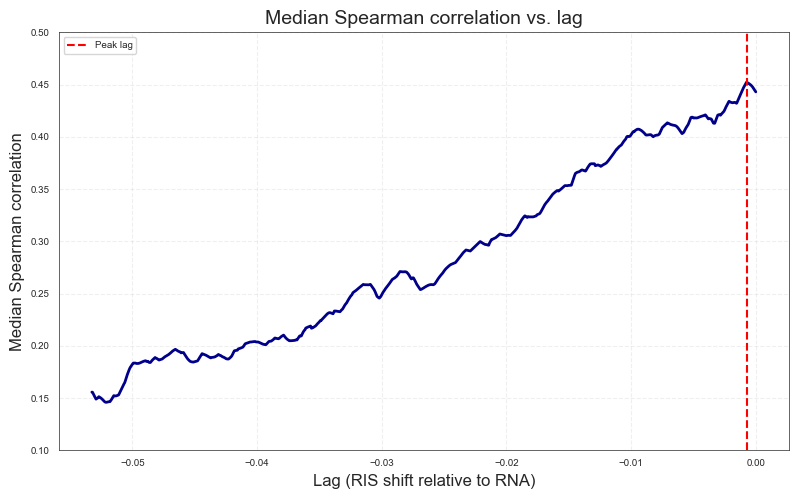

In [66]:
lags = np.arange(-4000, 1)
lags =  lags * median_dt
plt.figure(figsize=(8, 5))
plt.plot(lags, results['median_corr'], color='darkblue', linewidth=2)
plt.axvline(x=lags[np.nanargmax(results['median_corr'])], color='red', linestyle='--', label='Peak lag')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.title('Median Spearman correlation vs. lag', fontsize=14)
plt.xlabel('Lag (RIS shift relative to RNA)', fontsize=12)
plt.ylabel('Median Spearman correlation', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.ylim(0.1,0.5)
plt.tight_layout()
plt.show()


# 3. Differential Analysis of Key Transition Points

In [67]:
state_pre = pd.read_csv('../data/Pre_transition.txt', header=None)[0].values
state_post = pd.read_csv('../data/Post_transition.txt', header=None)[0].values
state_pre = np.intersect1d(state_pre, list(adata_edge.obs.index))
state_post = np.intersect1d(state_post, list(adata_edge.obs.index))

In [68]:
adata_edge.obs['state'] = adata_edge.obs['celltype_rna'].astype(str)  
adata_edge.obs.loc[state_pre, 'state'] = 'pre_transition'
adata_edge.obs.loc[state_post, 'state'] = 'post_transition'
# Filter to keep only cells in these two transition states
sub_data = adata_edge[adata_edge.obs['state'].isin(['pre_transition', 'post_transition'])]
print(sub_data.obs['state'].value_counts())

pre_transition     3279
post_transition     403
Name: state, dtype: int64


In [69]:
sc.tl.rank_genes_groups(sub_data, 'state', method='wilcoxon', groups=['post_transition'],reference='pre_transition')
select_edges = sc.get.rank_genes_groups_df(sub_data, group='post_transition')

In [70]:
edge_info = get_edge_info(dataset_atac)

In [71]:
select_edges['names'] = select_edges['names'].astype(str)
edge_info.index = edge_info.index.astype(str)
select_edges['peak'] = edge_info.loc[select_edges['names'], 'peak'].values
select_edges['gene'] = edge_info.loc[select_edges['names'], 'gene'].values
select_edges['pairs'] = select_edges['peak'] + '_' + select_edges['gene']

In [72]:
adata_rna.obs['state'] = adata_rna.obs['celltype'].astype(str)  
adata_rna.obs.loc[state_pre, 'state'] = 'pre_transition'
adata_rna.obs.loc[state_post, 'state'] = 'post_transition'
sub_data_rna = adata_rna[adata_rna.obs['state'].isin(['pre_transition', 'post_transition'])]
print(sub_data_rna.obs['state'].value_counts())

pre_transition     3279
post_transition     403
Name: state, dtype: int64


In [73]:
sub_data_rna

View of AnnData object with n_obs × n_vars = 3682 × 33958
    obs: 'celltype', 't', 'state'
    var: 'modality'

In [74]:
sc.tl.rank_genes_groups(sub_data_rna, 'state', method='wilcoxon', groups=['post_transition'],reference='pre_transition')
select_genes = sc.get.rank_genes_groups_df(sub_data_rna, group='post_transition')

### Rank

In [75]:
def calculate_gene_p_values(df, n_jobs=-1):
    """
    Perform KS-test on gene logFC values and return adjusted p-values.
    
    Args:
        df (pd.DataFrame): Input dataframe containing 'names' and 'logfoldchanges' columns.
        n_jobs (int): Number of parallel jobs to run (-1 means use all available cores).
    
    Returns:
        pd.DataFrame: Results dataframe with columns:
            - gene: Gene identifier
            - pvalue: Raw KS-test p-value
            - corrected_pvalue: FDR-adjusted p-value
            - ks_stat: KS test statistic
            Sorted by significance (corrected_pvalue)
    """
    # Standardize column names
    df.columns = ['gene', 'logfc']
    
    # Rank all logFC values (higher logFC gets better rank)
    ranks = rankdata(-df['logfc'].values)
    
    # Group ranks by gene
    gene_ranks = {}
    for gene, r in zip(df['gene'], ranks):
        gene_ranks.setdefault(gene, []).append(r)

    def ks_test(gene, granks):
        """Helper function to perform KS test for a single gene"""
        ks_stat, p = ks_2samp(granks, ranks, alternative='greater')
        return gene, p, ks_stat

    # Parallel execution of KS tests across genes
    results = Parallel(n_jobs=n_jobs)(
        delayed(ks_test)(g, gr) for g, gr in tqdm(gene_ranks.items(), desc="Performing KS tests")
    )

    # Create results dataframe
    res_df = pd.DataFrame(results, columns=['gene', 'pvalue', 'ks_stat'])
    
    # Apply FDR correction
    res_df['corrected_pvalue'] = multipletests(res_df['pvalue'], method='fdr_bh')[1]
    
    # Sort by significance and reset index
    return res_df.sort_values('corrected_pvalue').reset_index(drop=True)

In [76]:
select_edges = select_edges.dropna(subset=['logfoldchanges'])
select_edges.shape

(261977, 8)

In [77]:
select_edges_temp = select_edges[select_edges['peak'].str.startswith('chr')]

In [80]:
df_logFC_gene = select_edges_temp.loc[:, ['gene', 'logfoldchanges']].sort_values('logfoldchanges',ascending=False).reset_index(drop=True)
df_ris_logFC_gene  = calculate_gene_p_values(df_logFC_gene,n_jobs=30)


erforming KS tests: 100%|██████████| 3485/3485 [00:37<00:00, 94.05it/s] 

In [81]:
select_genes = select_genes.loc[select_genes.names.isin(select_edges_temp.gene.unique()),]
df_logFC_rna = (
    select_genes[['names', 'logfoldchanges']]
    .rename(columns={'names': 'gene'})
    .sort_values('logfoldchanges', ascending=False)
    .reset_index(drop=True)
)

### Enrichment

In [82]:
import gseapy as gp

# Get available gene set libraries
gene_set_libraries = gp.get_library_name()

# Filter for major pathway databases (KEGG, GO, WikiPathways, Reactome, MSigDB)
pathway_libraries = [lib for lib in gene_set_libraries 
                    if lib.startswith(('KEGG', 'GO', 'Wiki', 'Reactome', 'MSigDB'))]

print(pathway_libraries)  # Display filtered pathway databases

['GO_Biological_Process_2021', 'GO_Biological_Process_2023', 'GO_Biological_Process_2025', 'GO_Cellular_Component_2021', 'GO_Cellular_Component_2023', 'GO_Cellular_Component_2025', 'GO_Molecular_Function_2021', 'GO_Molecular_Function_2023', 'GO_Molecular_Function_2025', 'KEGG_2013', 'KEGG_2015', 'KEGG_2016', 'KEGG_2019_Human', 'KEGG_2019_Mouse', 'KEGG_2021_Human', 'MSigDB_Computational', 'MSigDB_Hallmark_2020', 'MSigDB_Oncogenic_Signatures', 'Reactome_2022', 'Reactome_Pathways_2024', 'WikiPathway_2021_Human', 'WikiPathway_2023_Human', 'WikiPathways_2013', 'WikiPathways_2015', 'WikiPathways_2016', 'WikiPathways_2019_Human', 'WikiPathways_2019_Mouse', 'WikiPathways_2024_Human', 'WikiPathways_2024_Mouse']


In [83]:
gene_set_library = 'KEGG_2021_Human'

In [84]:
top_n = 300

In [85]:
# Perform pathway enrichment analysis using Enrichr

# Get top genes from RIS analysis
top_ris_genes = df_ris_logFC_gene.head(top_n).gene.tolist()
enrichr_results_ris = gp.enrichr(
    gene_list=top_ris_genes,      # Gene list from differential regulation analysis
    gene_sets=gene_set_library,   # Pathway database to test against 
    organism='human',             # Organism (human/mouse/yeast)
    outdir=None,                  # Don't save output files
    cutoff=0.05                   # FDR significance threshold
)

# Get top genes from RNA-seq differential expression 
top_de_genes = df_logFC_rna.head(top_n).gene.tolist()
enrichr_results_rna = gp.enrichr(
    gene_list=top_de_genes,       # Gene list from differential expression
    gene_sets=gene_set_library,   # Same pathway database for comparison
    organism='human',             # Keep consistent organism  
    outdir=None,
    cutoff=0.05
)

In [86]:
enrich_ris = enrichr_results_ris.results.loc[enrichr_results_ris.results['Adjusted P-value']<0.05]
enrich_ris

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Focal adhesion,15/201,3.998948e-07,0.000092,0,0,5.521788,81.347341,TNC;PDGFA;PGF;VAV2;ACTG1;IGF1R;MAPK10;MYL5;CCN...
1,KEGG_2021_Human,ECM-receptor interaction,9/88,6.904346e-06,0.000794,0,0,7.681456,91.281508,FRAS1;GP1BB;ITGA11;TNC;DAG1;SPP1;COL6A3;COL9A3...
2,KEGG_2021_Human,PI3K-Akt signaling pathway,16/354,9.633580e-05,0.005438,0,0,3.227269,29.844720,LPAR1;TNC;PDGFA;PPP2R5A;PGF;IGF1R;G6PC3;CCND1;...
3,KEGG_2021_Human,Axon guidance,11/182,9.945095e-05,0.005438,0,0,4.346891,40.060277,EPHA4;MYL5;SEMA7A;RGS3;SEMA6A;DPYSL2;CFL1;UNC5...
4,KEGG_2021_Human,Regulation of actin cytoskeleton,12/218,1.182237e-04,0.005438,0,0,3.942961,35.655931,FGD3;MYL5;SPATA13;CFL1;ITGA11;LPAR1;PDGFA;HRAS...
5,KEGG_2021_Human,Rap1 signaling pathway,11/210,3.460880e-04,0.013267,0,0,3.729913,29.722992,ID1;LPAR1;PDGFA;HRAS;FGFR3;PGF;FGFR2;VAV2;GNAI...
6,KEGG_2021_Human,Endocytosis,12/252,4.477570e-04,0.014712,0,0,3.378472,26.052277,ARFGEF2;RAB31;WIPF1;BIN1;MVB12B;HRAS;FGFR3;FGF...
7,KEGG_2021_Human,Adherens junction,6/71,6.850034e-04,0.018713,0,0,6.164835,44.917523,TJP1;PTPRM;SNAI2;ACTG1;IGF1R;TGFBR2
8,KEGG_2021_Human,AGE-RAGE signaling pathway in diabetic complic...,7/100,7.759048e-04,0.018713,0,0,5.036845,36.071271,MAPK10;TGFB2;CCND1;BCL2;HRAS;F3;TGFBR2
9,KEGG_2021_Human,Hippo signaling pathway,9/163,8.135943e-04,0.018713,0,0,3.925425,27.925665,TGFB2;BMP2;CCND1;ID1;BMP8A;SNAI2;ACTG1;SMAD7;T...


In [87]:
enrich_rna = enrichr_results_rna.results.loc[enrichr_results_rna.results['Adjusted P-value']<0.05]
enrich_rna

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Ribosome,21/158,2.825931e-14,6.330086e-12,0,0,10.748057,335.310946,RPL3;RPL31;RPL12;RPLP0;RPL11;RPL36A;RPL35A;RPS...
1,KEGG_2021_Human,Coronavirus disease,23/232,9.259261e-13,1.037037e-10,0,0,7.743475,214.556066,CFD;RPL3;RPL31;RPL12;RPLP0;RPL11;RPL36A;RPL35A...
2,KEGG_2021_Human,ECM-receptor interaction,13/88,6.589775e-10,4.920365e-08,0,0,11.852497,250.565721,TNC;FN1;DMP1;NPNT;HSPG2;COL1A1;COL1A2;FRAS1;IB...
3,KEGG_2021_Human,Protein digestion and absorption,11/103,4.223435e-07,2.306359e-05,0,0,8.112231,119.066841,COL1A1;SLC8A3;COL1A2;SLC36A2;COL13A1;COL5A1;CO...
4,KEGG_2021_Human,Proteoglycans in cancer,15/205,5.148122e-07,2.306359e-05,0,0,5.404432,78.253278,CD63;CAMK2D;TGFB1;PTCH1;FN1;IHH;HSPG2;MMP9;COL...
5,KEGG_2021_Human,Axon guidance,12/182,2.052971e-05,7.664423e-04,0,0,4.786765,51.666604,SEMA5A;EFNA1;ENAH;CAMK2D;UNC5B;SEMA6D;PTCH1;PL...
6,KEGG_2021_Human,Diabetic cardiomyopathy,12/203,5.990046e-05,1.916815e-03,0,0,4.255890,41.379280,COL1A1;CAMK2D;COL1A2;TGFB1;UQCRB;TBC1D4;NDUFA4...
7,KEGG_2021_Human,"Parathyroid hormone synthesis, secretion and a...",8/106,1.973589e-04,5.526050e-03,0,0,5.480011,46.747161,MEF2A;MMP13;VDR;BGLAP;PTH1R;SOST;RUNX2;GNAI1
8,KEGG_2021_Human,PI3K-Akt signaling pathway,15/354,3.172296e-04,7.895492e-03,0,0,3.005900,24.215182,ANGPT1;FN1;TNC;EFNA5;COL1A1;EFNA1;COL1A2;IBSP;...
9,KEGG_2021_Human,Focal adhesion,10/201,9.479732e-04,2.123460e-02,0,0,3.522116,24.518098,COL1A1;COL1A2;IBSP;CHAD;FN1;SPP1;TNC;COL6A3;FL...


### subgraph

In [88]:
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [89]:
# 1. Load and preprocess data
pos_edges = select_edges[select_edges['logfoldchanges'] > 0].copy()

In [90]:
# Separate enhancer and promoter edges
is_enhancer = pos_edges['peak'].str.startswith('chr')
enhancer_edges = pos_edges[is_enhancer]
promoter_edges = pos_edges[~is_enhancer]
print(f"Enhancer edges: {len(enhancer_edges)}, Promoter edges: {len(promoter_edges)}")

Enhancer edges: 116290, Promoter edges: 7815


In [91]:
# 2. Normalize weights using Z-score
def zscore_norm(series):
    return (series - series.mean()) / series.std()

pos_edges['logfoldchanges'] = pd.concat([
    zscore_norm(enhancer_edges['logfoldchanges']),
    zscore_norm(promoter_edges['logfoldchanges'])
])

# 3. Create graph data
# Node mapping
nodes = pd.unique(pd.concat([pos_edges['peak'], pos_edges['gene']]))
node_idx = {n: i for i, n in enumerate(nodes)}

# Edge connections
edge_index = torch.tensor([
    [node_idx[peak] for peak in pos_edges['peak']],
    [node_idx[gene] for gene in pos_edges['gene']]
], dtype=torch.long)

# Edge weights
edge_attr = torch.tensor(pos_edges['logfoldchanges'].values, dtype=torch.float).view(-1, 1)

# Create PyG Data object
graph_data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(nodes))

# 4. Convert to NetworkX graph
G = nx.Graph()
for (peak, gene), weight in zip(pos_edges[['peak', 'gene']].values, pos_edges['logfoldchanges']):
    G.add_edge(peak, gene, weight=weight)


Cluster Statistics:
Cluster 0: Edge Count =  37717 | Avg Weight = 0.0643
Cluster 1: Edge Count =  65233 | Avg Weight = -0.5848
Cluster 2: Edge Count =   1218 | Avg Weight = 5.6581
Cluster 3: Edge Count =   4995 | Avg Weight = 2.6836
Cluster 4: Edge Count =  14781 | Avg Weight = 1.0399

Highest-weight Cluster: 2, Avg Weight: 5.66


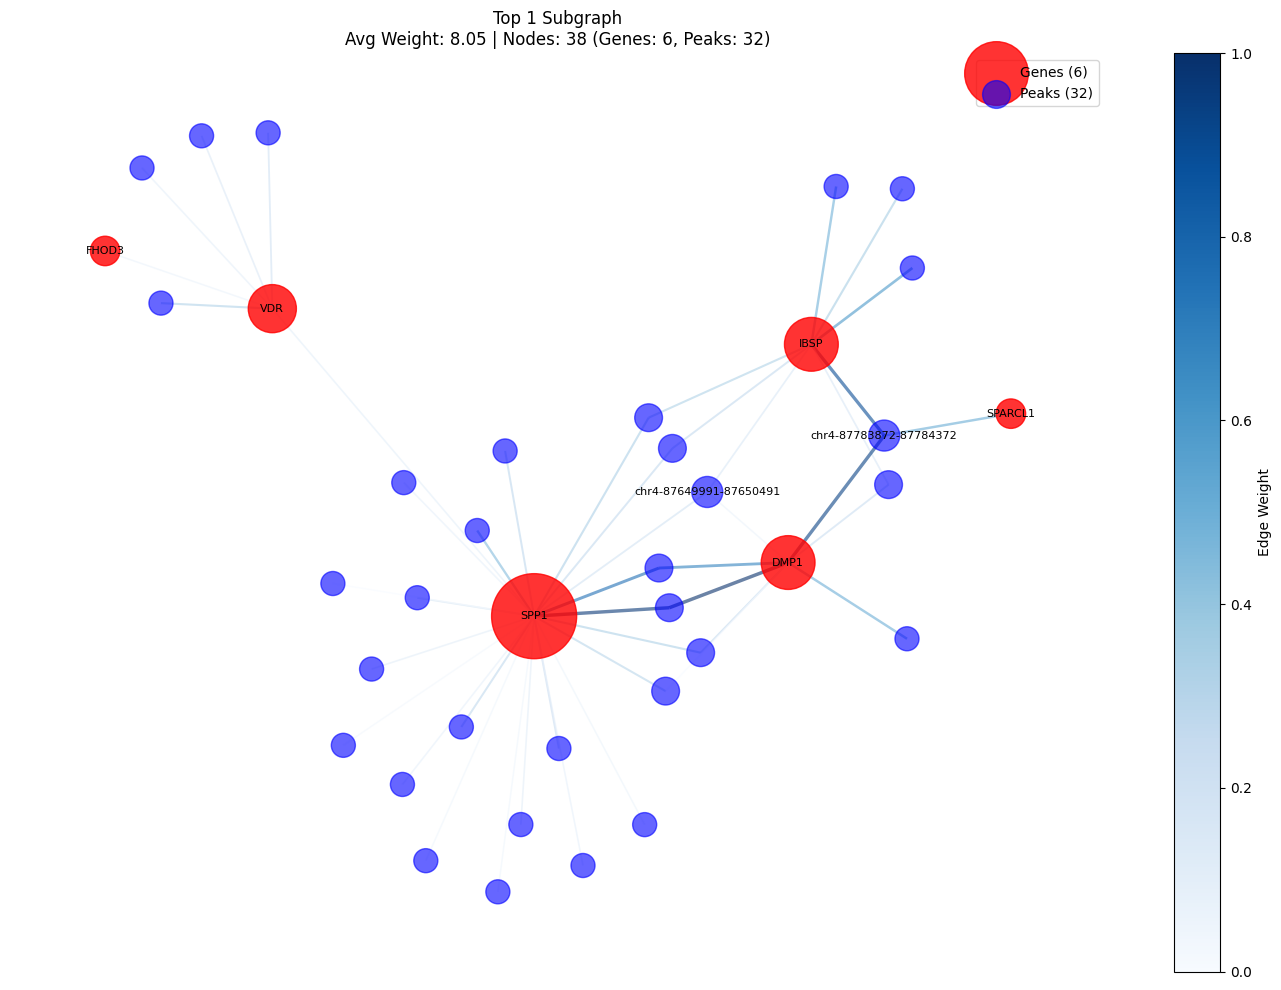


Subgraph 1 Details:
- Avg Edge Weight: 8.0519
- Nodes: 38 (Genes: 6, Peaks: 32)
- Edges: 45
- Gene-Gene Connections:
  SPP1 -- VDR: 5.6195
  FHOD3 -- VDR: 5.2066
- Gene-Peak Connections:
  chr4-87983497-87983997 -- DMP1: 16.4423
  chr4-87983497-87983997 -- SPP1: 16.0683
  DMP1 -- chr4-87783872-87784372: 15.6931
  IBSP -- chr4-87783872-87784372: 15.1494
  SPP1 -- chr4-87984130-87984630: 13.5274


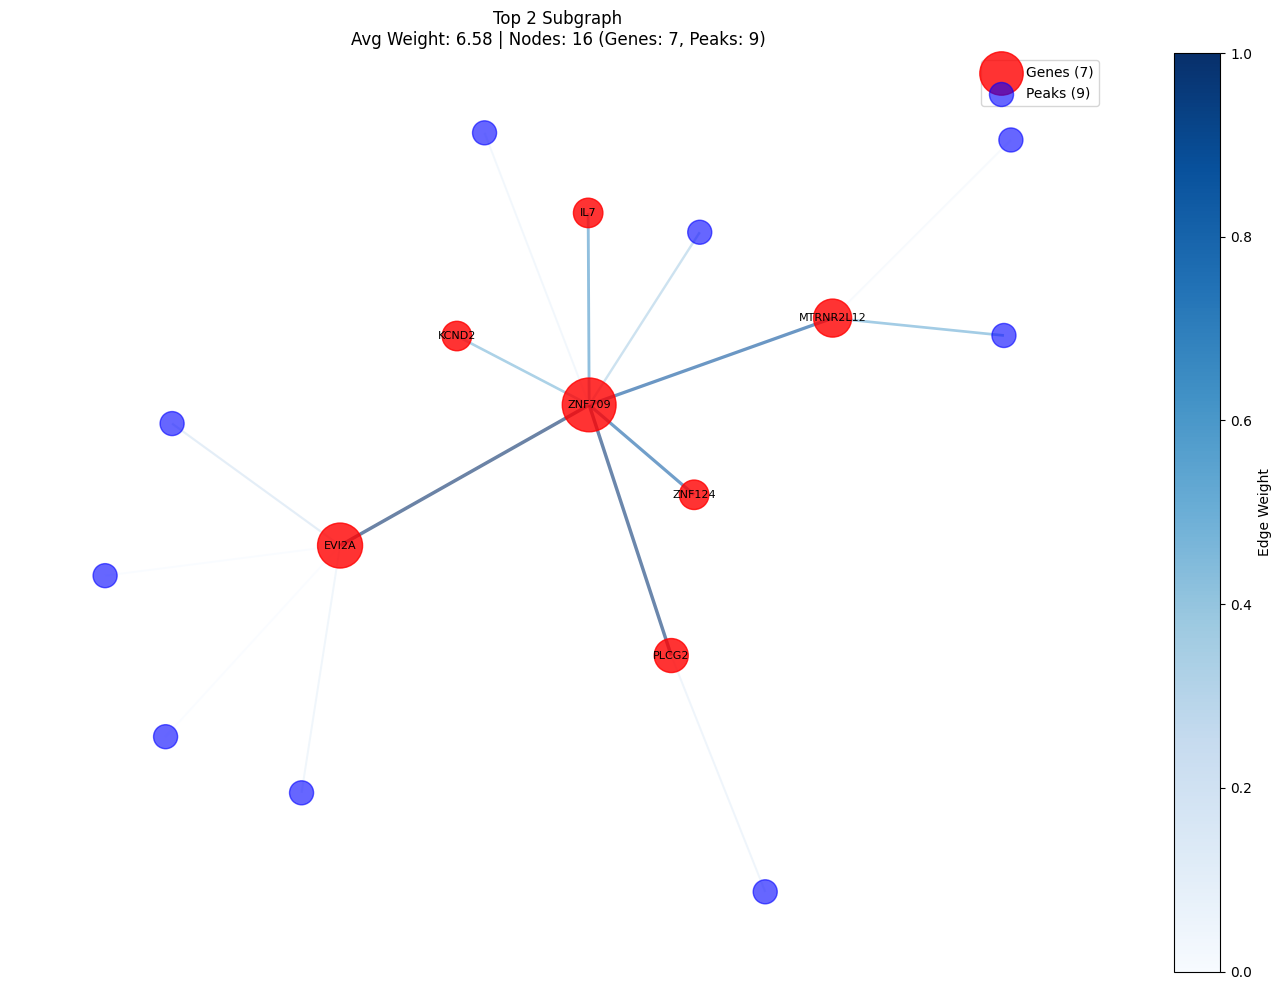


Subgraph 2 Details:
- Avg Edge Weight: 6.5753
- Nodes: 16 (Genes: 7, Peaks: 9)
- Edges: 15
- Gene-Gene Connections:
  EVI2A -- ZNF709: 10.0552
  ZNF709 -- PLCG2: 9.8730
  MTRNR2L12 -- ZNF709: 9.2897
  ZNF709 -- ZNF124: 9.0012
  IL7 -- ZNF709: 7.7939
- Gene-Peak Connections:
  MTRNR2L12 -- chr3-96134872-96135372: 7.2226
  ZNF709 -- chr19-11877838-11878338: 6.1516
  chr17-31449092-31449592 -- EVI2A: 5.3125
  chr16-81896847-81897347 -- PLCG2: 4.7540
  EVI2A -- chr17-31406241-31406741: 4.7248


In [92]:
def analyze_high_weight_subgraphs(G, min_nodes=5, n_clusters=5, clustering_method='gmm',
                                min_genes=2, min_peaks=1):
    """
    Identify high-weight subgraphs through edge weight clustering
    
    Args:
        G: Input NetworkX graph
        min_nodes: Minimum number of nodes required in subgraphs
        n_clusters: Number of clusters for edge weight partitioning
        clustering_method: Clustering algorithm ('kmeans' or 'gmm')
        min_genes: Minimum gene nodes required in valid subgraphs  
        min_peaks: Minimum peak nodes required in valid subgraphs
    Returns:
        List of valid subgraphs sorted by average edge weight (descending)
    """
    # Extract edge weights and reshape for clustering
    edge_weights = np.array([d['weight'] for _, _, d in G.edges(data=True)])
    edge_weights = edge_weights.reshape(-1, 1)
    
    # Perform edge weight clustering
    if clustering_method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    else:
        model = GaussianMixture(n_components=n_clusters, random_state=42)
    
    clusters = model.fit_predict(edge_weights)
    
    # Print cluster statistics
    print("\nCluster Statistics:")
    for i in range(n_clusters):
        cluster_size = np.sum(clusters == i)
        cluster_mean = edge_weights[clusters == i].mean()
        print(f"Cluster {i}: Edge Count = {cluster_size:6d} | Avg Weight = {cluster_mean:.4f}")
    
    # Identify highest-weight cluster
    cluster_means = [edge_weights[clusters == i].mean() for i in range(n_clusters)]
    best_cluster = np.argmax(cluster_means)
    print(f"\nHighest-weight Cluster: {best_cluster}, Avg Weight: {cluster_means[best_cluster]:.2f}")
    
    # Extract edges from the best cluster
    edges = np.array(G.edges())
    high_weight_edges = edges[clusters == best_cluster]
    
    # Create subgraph containing only high-weight edges
    subgraph = nx.Graph()
    for u, v in high_weight_edges:
        subgraph.add_edge(u, v, weight=G[u][v]['weight'])
    
    # Get connected components as candidate subgraphs
    connected_subgraphs = [subgraph.subgraph(c) for c in nx.connected_components(subgraph)]
    
    # Filter subgraphs based on node requirements
    def is_valid_subgraph(sg):
        """Check if subgraph meets node type and count requirements"""
        genes = [n for n in sg.nodes() if not str(n).startswith('chr')]
        peaks = [n for n in sg.nodes() if str(n).startswith('chr')]
        return (sg.number_of_nodes() >= min_nodes and 
                len(genes) >= min_genes and 
                len(peaks) >= min_peaks)
    
    # Collect valid subgraphs with their statistics
    valid_subgraphs = []
    for sg in connected_subgraphs:
        if is_valid_subgraph(sg):
            avg_weight = np.mean([d['weight'] for _, _, d in sg.edges(data=True)])
            genes = [n for n in sg.nodes() if not str(n).startswith('chr')]
            peaks = [n for n in sg.nodes() if str(n).startswith('chr')]
            valid_subgraphs.append((sg, avg_weight, len(genes), len(peaks)))
    
    if not valid_subgraphs:
        print(f"No valid subgraphs found (nodes>={min_nodes}, genes>={min_genes}, peaks>={min_peaks})")
        return None
    
    # Sort subgraphs by average edge weight (descending)
    return sorted(valid_subgraphs, key=lambda x: -x[1])

def visualize_top_subgraphs(subgraphs, top_n=10):
    """
    Visualize the top N highest-weight subgraphs
    
    Args:
        subgraphs: List of subgraphs from analyze_high_weight_subgraphs()
        top_n: Number of top subgraphs to visualize
    """
    for i, (sg, avg_weight, gene_count, peak_count) in enumerate(subgraphs[:top_n]):
        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(sg, seed=42, k=0.15)  # Consistent layout
        
        # Separate genes and peaks
        genes = [n for n in sg.nodes() if not str(n).startswith('chr')]
        peaks = [n for n in sg.nodes() if str(n).startswith('chr')]
        
        # Prepare visualization parameters
        weights = np.array([d['weight'] for _, _, d in sg.edges(data=True)])
        degrees = np.array([sg.degree(n) for n in sg.nodes()])
        
        # Draw nodes with size proportional to degree
        nx.draw_networkx_nodes(sg, pos, nodelist=genes,
                             node_size=300 + 150 * np.array([sg.degree(n) for n in genes]),
                             node_color='red', alpha=0.8, label=f'Genes ({gene_count})')
        nx.draw_networkx_nodes(sg, pos, nodelist=peaks,
                             node_size=200 + 100 * np.array([sg.degree(n) for n in peaks]),
                             node_color='blue', alpha=0.6, label=f'Peaks ({peak_count})')
        
        # Draw edges with width/color reflecting weight
        nx.draw_networkx_edges(sg, pos, 
                             width=0.5 + 2 * weights / weights.max(),
                             edge_color=weights,
                             edge_cmap=plt.cm.Blues,
                             alpha=0.6)
        
        # Label important nodes (high degree or genes)
        labels = {n: n for n in sg.nodes() 
                if sg.degree(n) > np.mean(degrees) or n in genes}
        nx.draw_networkx_labels(sg, pos, labels, font_size=8)
        
        plt.title(f"Top {i+1} Subgraph\nAvg Weight: {avg_weight:.2f} | Nodes: {sg.number_of_nodes()} (Genes: {gene_count}, Peaks: {peak_count})")
        plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label='Edge Weight')
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print subgraph details
        print(f"\nSubgraph {i+1} Details:")
        print(f"- Avg Edge Weight: {avg_weight:.4f}")
        print(f"- Nodes: {sg.number_of_nodes()} (Genes: {gene_count}, Peaks: {peak_count})")
        print(f"- Edges: {sg.number_of_edges()}")
        
        # Print top gene-gene connections (if any)
        gene_edges = [(u, v, d) for u, v, d in sg.edges(data=True) 
                     if not str(u).startswith('chr') and not str(v).startswith('chr')]
        if gene_edges:
            print("- Gene-Gene Connections:")
            for u, v, d in sorted(gene_edges, key=lambda x: -x[2]['weight'])[:5]:
                print(f"  {u} -- {v}: {d['weight']:.4f}")
        
        # Print top gene-peak connections
        print("- Gene-Peak Connections:")
        gene_peak_edges = [(u, v, d) for u, v, d in sg.edges(data=True) 
                          if (not str(u).startswith('chr') and str(v).startswith('chr')) or 
                          (str(u).startswith('chr') and not str(v).startswith('chr'))]
        for u, v, d in sorted(gene_peak_edges, key=lambda x: -x[2]['weight'])[:5]:
            print(f"  {u} -- {v}: {d['weight']:.4f}")

# Example Usage
if __name__ == "__main__":
    # Assuming G is already loaded
    subgraphs = analyze_high_weight_subgraphs(
        G, 
        min_nodes=5, 
        n_clusters=5, 
        clustering_method='gmm',
        min_genes=3, 
        min_peaks=2
    )
    
    if subgraphs:
        visualize_top_subgraphs(subgraphs, top_n=2)